In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2


train = pd.read_csv('digit-recognizer/train.csv')
test = pd.read_csv('digit-recognizer/test.csv')
sudoku = pd.read_csv('sudoku_digits.csv')

In [3]:
cols = train.columns
sudoku.drop('Unnamed: 0', axis=1, inplace=True)
sudoku.columns = cols
new = pd.concat([train, sudoku], axis=0, ignore_index=True)
new

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
digit_features = new.copy()
digit_label = digit_features.pop('label')

In [5]:
digit_features.head(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
digit_features = digit_features.to_numpy().reshape(-1,28,28)
digit_label = digit_label.to_numpy()

In [83]:
digit_features = tf.expand_dims(digit_features, axis=-1)
digit_label = tf.one_hot(digit_label, depth = 10, on_value=1, axis=-1)

In [85]:
size = new.shape[0]//10

x_train, x_val = tf.split(digit_features, [size*8, size*2])
y_train, y_val = tf.split(digit_label, [size*8, size*2])

In [86]:
x_train.shape

TensorShape([34320, 28, 28, 1])

In [87]:
model = tf.keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=5, activation='relu', padding='valid',
                  input_shape=(28, 28, 1)),
    layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    
    layers.Conv2D(filters=64, kernel_size=5, activation='relu', padding='valid'),
    layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    
    layers.Flatten(),
    layers.Dense(10, activation='softmax'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

early_stopping = callbacks.EarlyStopping(patience=5, min_delta=0.001, restore_best_weights=True)


In [88]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=420, epochs=30, callbacks=early_stopping, verbose=2)

Epoch 1/30
82/82 - 14s - loss: 3.4420 - categorical_accuracy: 0.7621 - val_loss: 0.3870 - val_categorical_accuracy: 0.9076
Epoch 2/30
82/82 - 13s - loss: 0.2196 - categorical_accuracy: 0.9401 - val_loss: 0.2059 - val_categorical_accuracy: 0.9486
Epoch 3/30
82/82 - 14s - loss: 0.1221 - categorical_accuracy: 0.9644 - val_loss: 0.1683 - val_categorical_accuracy: 0.9559
Epoch 4/30
82/82 - 14s - loss: 0.0825 - categorical_accuracy: 0.9755 - val_loss: 0.1201 - val_categorical_accuracy: 0.9568
Epoch 5/30
82/82 - 15s - loss: 0.0591 - categorical_accuracy: 0.9816 - val_loss: 0.1069 - val_categorical_accuracy: 0.9633
Epoch 6/30
82/82 - 14s - loss: 0.0443 - categorical_accuracy: 0.9875 - val_loss: 0.0982 - val_categorical_accuracy: 0.9641
Epoch 7/30
82/82 - 14s - loss: 0.0322 - categorical_accuracy: 0.9900 - val_loss: 0.0945 - val_categorical_accuracy: 0.9666
Epoch 8/30
82/82 - 14s - loss: 0.0246 - categorical_accuracy: 0.9930 - val_loss: 0.0831 - val_categorical_accuracy: 0.9804
Epoch 9/30
82/82

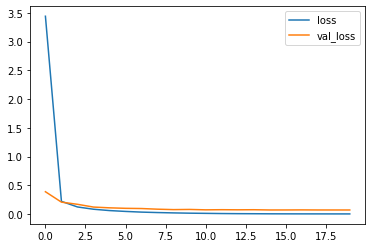

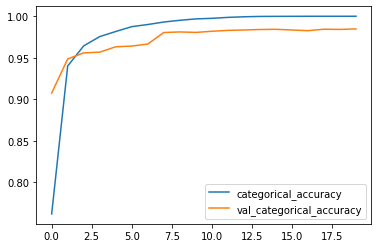

In [89]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot();

In [102]:
def model_predict(num):
    num = str(num)
    image = cv2.imread('{num}.jpg'.format(num=num), cv2.IMREAD_GRAYSCALE)
    image = 255 - image
    image = tf.expand_dims(image, axis=-1)
    image = tf.expand_dims(image, axis=0)
    number = model(image)
    
    return np.argmax(number, axis=1)[0]

In [103]:
model_predict(1)

1

In [108]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets
